In [47]:
import pandas as pd
file_path = "MBTA_Bus_Ridership_by_Trip%2C_Season%2C_Route_Line%2C_and_Stop (1).csv"
df = pd.read_csv(file_path)
print(df.head())

C:\Users\junhy\AppData\Local\Temp\ipykernel_33232\708438445.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


      season route_id route_variant  direction_id trip_start_time  \
0  Fall 2016        1         1-0-0             0        04:37:00   
1  Fall 2016        1         1-0-0             0        04:37:00   
2  Fall 2016        1         1-0-0             0        04:37:00   
3  Fall 2016        1         1-0-0             0        04:37:00   
4  Fall 2016        1         1-0-0             0        04:37:00   

   day_type_id day_type_name                      stop_name  stop_id  \
0  day_type_01       weekday   WASHINGTON ST OPP RUGGLES ST        1   
1  day_type_01       weekday       ALBANY ST OPP RANDALL ST    10003   
2  day_type_01       weekday  MASSACHUSETTS AVE @ SIDNEY ST      101   
3  day_type_01       weekday   MASSACHUSETTS AVE @ PROSPECT      102   
4  day_type_01       weekday  MASSACHUSETTS AVE @ BIGELOW S      104   

   stop_sequence  boardings  alightings  load_  sample_size  ObjectId  
0              2        0.4         0.3    7.8           13         1  
1       

In [48]:
# Group by 'season' first to process each chunk
season_chunks = df.groupby('season')

# List to hold all aggregated DataFrames for each season
aggregated_df_list = []

for season, season_data in season_chunks:
    # Sort by route_id, direction_id, stop_sequence, and stop_id to ensure correct order
    season_data = season_data.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])
    
    # Perform aggregation (sum of boardings and alightings)
    aggregated_season_df = season_data.groupby(['season', 'route_id', 'direction_id', 'stop_sequence', 'stop_id', 'stop_name']).agg(
        avg_boardings=('boardings', 'sum'),
        avg_alightings=('alightings', 'sum')
    ).reset_index()
    
    # Add 'traffic' column by summing boardings and alightings
    aggregated_season_df['traffic'] = aggregated_season_df['avg_boardings'] + aggregated_season_df['avg_alightings']
    
    # Sort to maintain order
    aggregated_season_df = aggregated_season_df.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])

    # Add to the list of DataFrames
    aggregated_df_list.append(aggregated_season_df)

# Combine all chunks into one DataFrame
final_aggregated_df = pd.concat(aggregated_df_list, ignore_index=True)

# Print the final aggregated DataFrame
print(final_aggregated_df)


             season route_id  direction_id  stop_sequence  stop_id  \
0         Fall 2016        1             0              1       64   
1         Fall 2016        1             0              2        1   
2         Fall 2016        1             0              3        2   
3         Fall 2016        1             0              4        6   
4         Fall 2016        1             0              5    10003   
...             ...      ...           ...            ...      ...   
127162  Spring 2024       47             0             30     1813   
127163  Spring 2024       47             0             31     1814   
127164  Spring 2024       47             0             32     1816   
127165  Spring 2024       47             0             33     2755   
127166  Spring 2024       47             0             34     1123   

                            stop_name  avg_boardings  avg_alightings  traffic  
0                      DUDLEY STATION         2629.7             0.0   2629.7  

In [49]:
stops = pd.read_csv("stops.csv")
print("Preview of the CSV data:")
print("Hello" ,final_aggregated_df.size)
print(stops.head())
print("\nColumns in the CSV:", stops.columns)

stops['route'] = stops['stop_desc'].astype(str)  
stops = stops.dropna(subset=['route'])

merged_coordinates = stops.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first'
})


final_aggregated_df = final_aggregated_df.drop(columns=['stop_lat', 'stop_lon'], errors='ignore')
final_aggregated_df = pd.merge(final_aggregated_df, merged_coordinates, on='stop_id', how='left')
print("\nFinal Merged DataFrame with Coordinates:")
print(final_aggregated_df)


Preview of the CSV data:
Hello 1144503
   stop_id  stop_code                      stop_name stop_desc platform_code  \
0      1.0        1.0   Washington St opp Ruggles St       NaN           NaN   
1     10.0       10.0  Theo Glynn Way @ Newmarket Sq       NaN           NaN   
2  10000.0    10000.0       Tremont St opp Temple Pl       NaN           NaN   
3  10003.0    10003.0       Albany St opp Randall St       NaN           NaN   
4  10005.0    10005.0     Albany St opp E Concord St       NaN           NaN   

  platform_name   stop_lat   stop_lon              zone_id stop_address  \
0           NaN  42.330957 -71.082754  ExpressBus-Downtown          NaN   
1           NaN  42.330555 -71.068787             LocalBus          NaN   
2           NaN  42.355692 -71.062911             LocalBus          NaN   
3           NaN  42.331591 -71.076237             LocalBus          NaN   
4           NaN  42.335017 -71.071280             LocalBus          NaN   

                           st

In [50]:
columns_to_drop = [
    'platform_code', 'stop_desc', 'parent_station', 'wheelchair_boarding',
    'platform_name', 'zone_id', 'stop_address', 'stop_url',
    'level_id', 'location_type', 'municipality','platform_code_x', 'platform_name_x'
]

final_aggregated_df = final_aggregated_df.drop(columns=columns_to_drop, errors='ignore')  

# Display DataFrame
print("DataFrame after removing unwanted columns:")
print(final_aggregated_df.columns)

DataFrame after removing unwanted columns:
Index(['season', 'route_id', 'direction_id', 'stop_sequence', 'stop_id',
       'stop_name', 'avg_boardings', 'avg_alightings', 'traffic', 'stop_lat',
       'stop_lon'],
      dtype='object')


In [51]:
# Drop duplicate columns keeping only the final versions
final_aggregated_df = final_aggregated_df.drop(columns=[
    'stop_name_x', 'stop_name_y', 'route_x', 'route_y', 'stop_code_x', 'stop_code_y',
    'stop_desc_x', 'stop_desc_y', 'platform_code_y', 'platform_name_y',
    'stop_lat_x', 'stop_lat_y', 'stop_lon_x', 'stop_lon_y', 'zone_id_x', 'zone_id_y',
    'stop_address_x', 'stop_address_y', 'stop_url_x', 'stop_url_y', 'level_id_x', 'level_id_y',
    'location_type_x', 'location_type_y', 'parent_station_x', 'parent_station_y',
    'wheelchair_boarding_x', 'wheelchair_boarding_y', 'municipality_x', 'municipality_y',
    'on_street_x', 'on_street_y', 'at_street_x', 'at_street_y', 'vehicle_type_x', 'vehicle_type_y'
], errors='ignore')


print("Final Cleaned DataFrame:")
final_aggregated_df.to_csv("cleaned_final_set(post 2019).csv", index = False)
print(final_aggregated_df)


Final Cleaned DataFrame:
             season route_id  direction_id  stop_sequence  stop_id  \
0         Fall 2016        1             0              1       64   
1         Fall 2016        1             0              2        1   
2         Fall 2016        1             0              3        2   
3         Fall 2016        1             0              4        6   
4         Fall 2016        1             0              5    10003   
...             ...      ...           ...            ...      ...   
127162  Spring 2024       47             0             30     1813   
127163  Spring 2024       47             0             31     1814   
127164  Spring 2024       47             0             32     1816   
127165  Spring 2024       47             0             33     2755   
127166  Spring 2024       47             0             34     1123   

                            stop_name  avg_boardings  avg_alightings  traffic  \
0                      DUDLEY STATION         2629.7 

Hello 43686


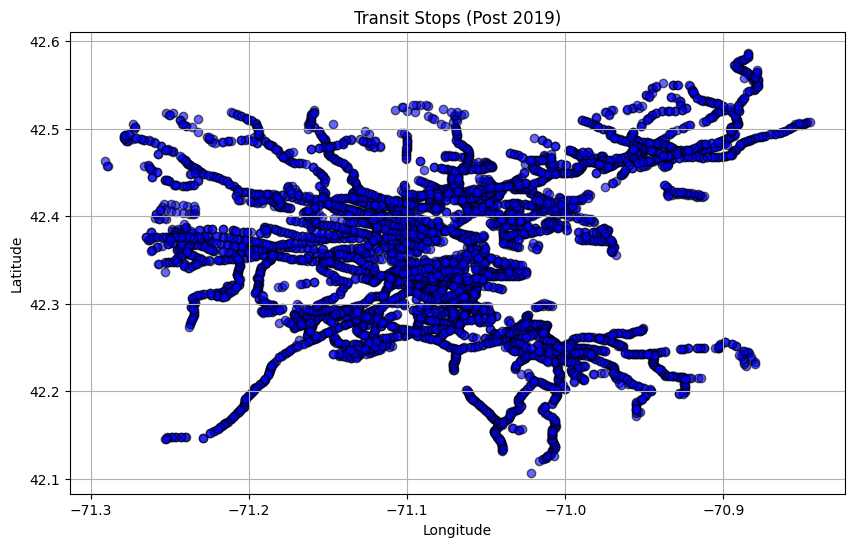

In [54]:
import matplotlib.pyplot as plt


final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]
print("Hello", final_aggregated_df.size)

final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',  
    'stop_lon': 'first',
    'season': 'first',  
    'traffic': 'sum' 
})

plt.figure(figsize=(10, 6))
plt.scatter(final_aggregated_df['stop_lon'], final_aggregated_df['stop_lat'], alpha=0.6, c='blue', edgecolors='black')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (Post 2019)")
plt.grid(True)
plt.show()

Hello 43686


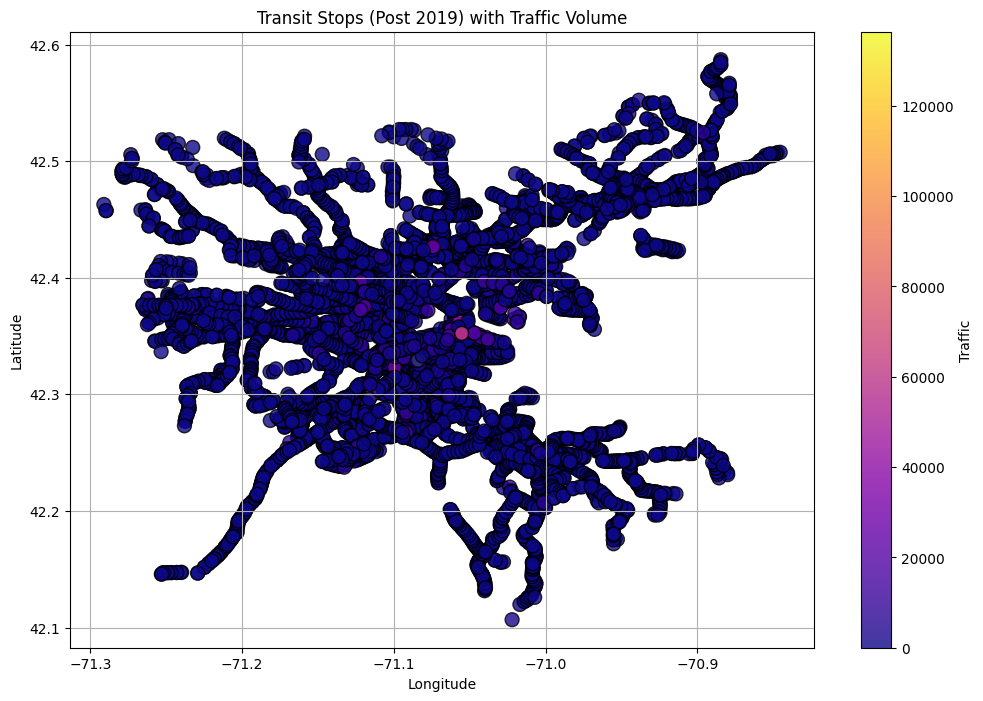

In [56]:
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]
print("Hello", final_aggregated_df.size)
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first',
    'season': 'first',
    'traffic': 'sum'
})

# Normalize the traffic (to map it to a color scale)
traffic = final_aggregated_df['traffic']
norm = plt.Normalize(traffic.min(), traffic.max())
cmap = plt.get_cmap("plasma")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_aggregated_df['stop_lon'],
    final_aggregated_df['stop_lat'],
    c=traffic,
    cmap=cmap,
    alpha=0.8,
    edgecolors='black',
    norm=norm,
    s=100
)

plt.colorbar(scatter, label='Traffic')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (Post 2019) with Traffic Volume")
plt.grid(True)
plt.show()


Empty DataFrame
Columns: [stop_id, stop_lat, stop_lon, season, traffic]
Index: []
Upper bound for outlier detection: 1016.8499999999999


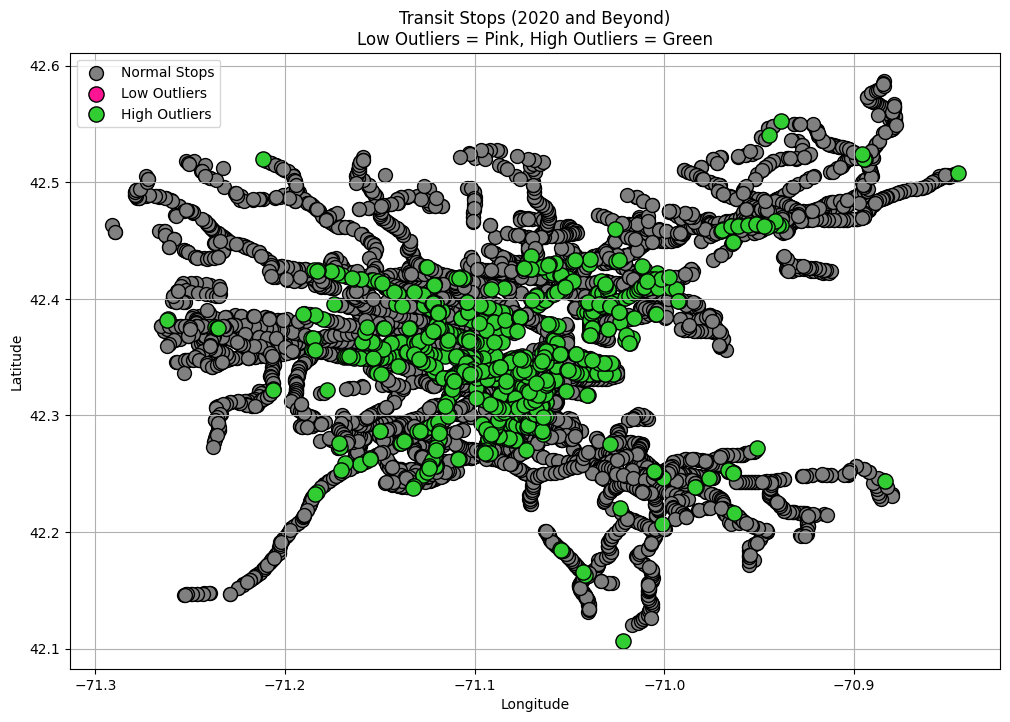

In [57]:
# Extract year and filter for years after 2019
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]

# Group by stop_id and aggregate lat/lon by taking the first value
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first',
    'season': 'first',
    'traffic': 'sum' 
})

# Compute IQR for traffic to detect outliers
Q1 = final_aggregated_df['traffic'].quantile(0.25)
Q3 = final_aggregated_df['traffic'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds (lower bound set to >= 0)
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Classify data points
low_outliers = final_aggregated_df[final_aggregated_df['traffic'] < lower_bound]      # Bright Pink
high_outliers = final_aggregated_df[final_aggregated_df['traffic'] > upper_bound]     # Green
normal_data = final_aggregated_df[(final_aggregated_df['traffic'] >= lower_bound) & 
                                  (final_aggregated_df['traffic'] <= upper_bound)]

print(low_outliers)
print("Upper bound for outlier detection:", upper_bound)

# Plot the stops
plt.figure(figsize=(12, 8))

# Normal stops
plt.scatter(normal_data['stop_lon'], normal_data['stop_lat'], 
            color='gray', edgecolors='black', s=100, label='Normal Stops')

# Low traffic outliers
plt.scatter(low_outliers['stop_lon'], low_outliers['stop_lat'], 
            color='deeppink', edgecolors='black', s=120, label='Low Outliers')

# High traffic outliers
plt.scatter(high_outliers['stop_lon'], high_outliers['stop_lat'], 
            color='limegreen', edgecolors='black', s=120, label='High Outliers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (2020 and Beyond)\nLow Outliers = Pink, High Outliers = Green")
plt.legend()
plt.grid(True)
plt.show()


## K MEANS

In [20]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

file_path = "cleaned_final_set(post 2019).csv"
df = pd.read_csv(file_path)

df.head()

,stop_id,season,traffic,stop_lat,stop_lon
0,1,Fall 2020,1456.500000,42.330957,-71.082754
1,2,Fall 2020,1445.600000,42.332324,-71.081252
2,3,Fall 2020,3562.433333,42.333021,-71.080799
3,4,Fall 2020,4495.455555,42.335164,-71.078518
4,5,Fall 2020,7998.288888,42.336339,-71.077070


In [21]:
df['year'] = df['season'].str.extract(r'(\d{4})').astype(float)
df = df[df['year'] > 2019]

grouped_df = df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',   
    'stop_lon': 'first',   
    'traffic': 'sum'       
})

grouped_df['grouped_season'] = "2020 and beyond"

# Display the grouped dataset
print(grouped_df.head())


   stop_id   stop_lat   stop_lon      traffic   grouped_season
0        1  42.330957 -71.082754  1456.500000  2020 and beyond
1        2  42.332324 -71.081252  1445.600000  2020 and beyond
2        3  42.333021 -71.080799  3562.433333  2020 and beyond
3        4  42.335164 -71.078518  4495.455555  2020 and beyond
4        5  42.336339 -71.077070  7998.288888  2020 and beyond


In [22]:
grouped_df = df.dropna(subset=["stop_lat", "stop_lon"])

X = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
X["traffic"] = (X["traffic"] - X["traffic"].mean()) / X["traffic"].std()

cost = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)

C:\Users\junhy\AppData\Local\Temp\ipykernel_33232\3639643906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["cluster"] = kmeans.fit_predict(X)


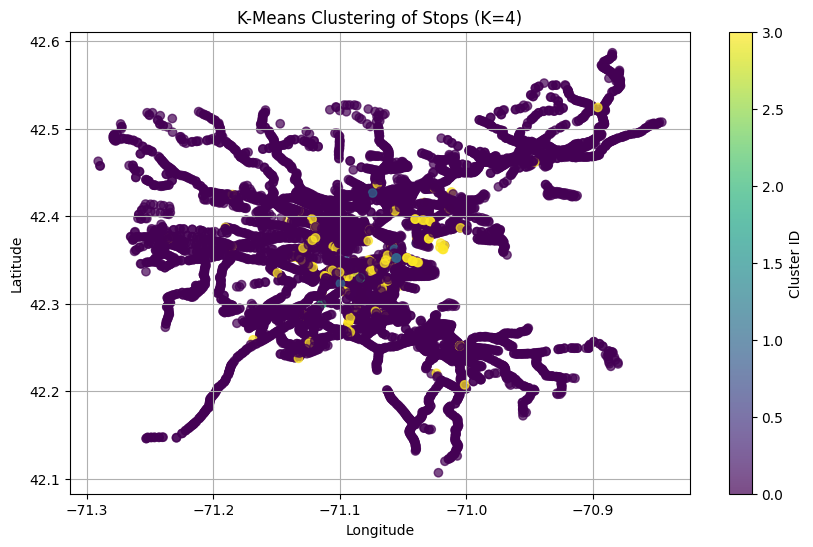

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
grouped_df["cluster"] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means Clustering of Stops (K={4})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

In [28]:
cluster_ridership_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_ridership_summary

,cluster,traffic
0,0,391.739872
1,1,42621.730151
2,2,113158.321111
3,3,8332.145609


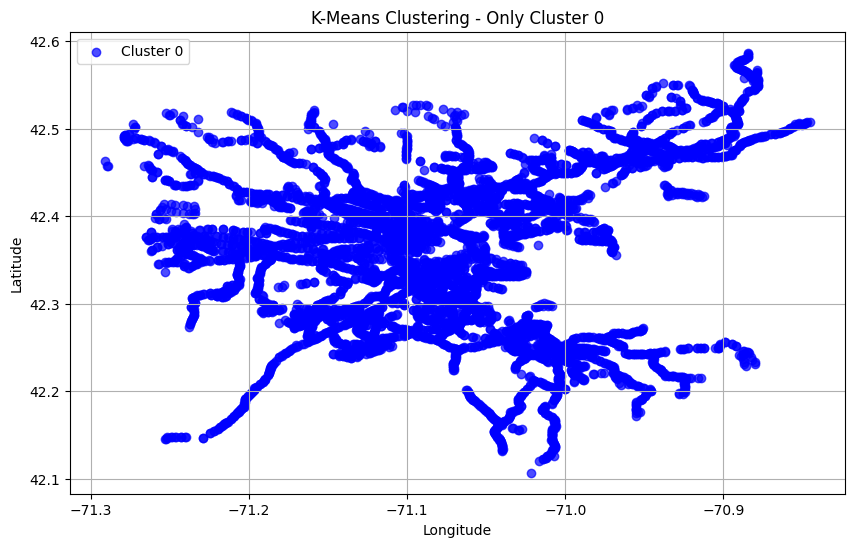

In [29]:
cluster_0_df = grouped_df[grouped_df["cluster"] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_0_df["stop_lon"], cluster_0_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()

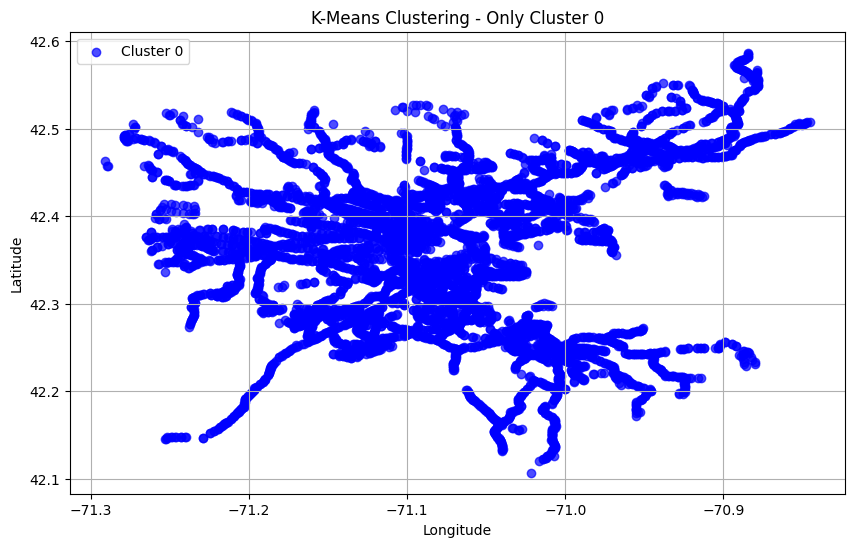

In [32]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()

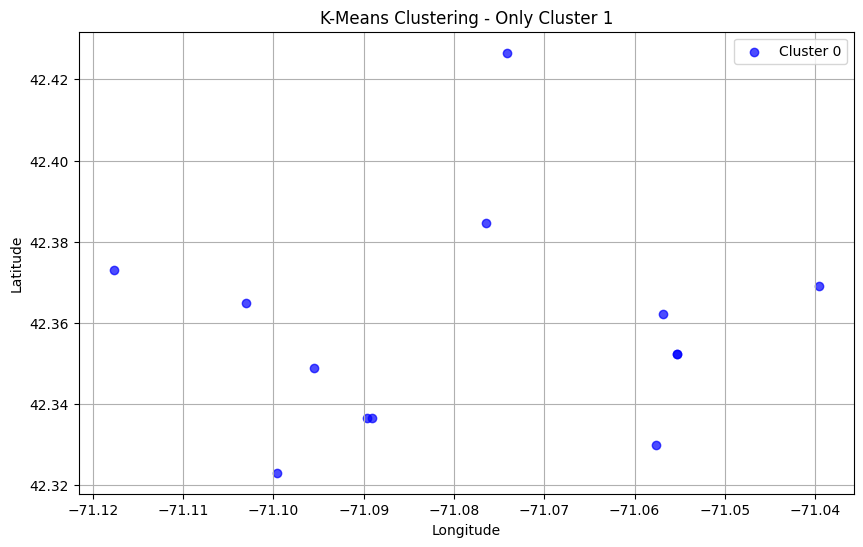

In [30]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 1")
plt.legend()
plt.grid(True)
plt.show()

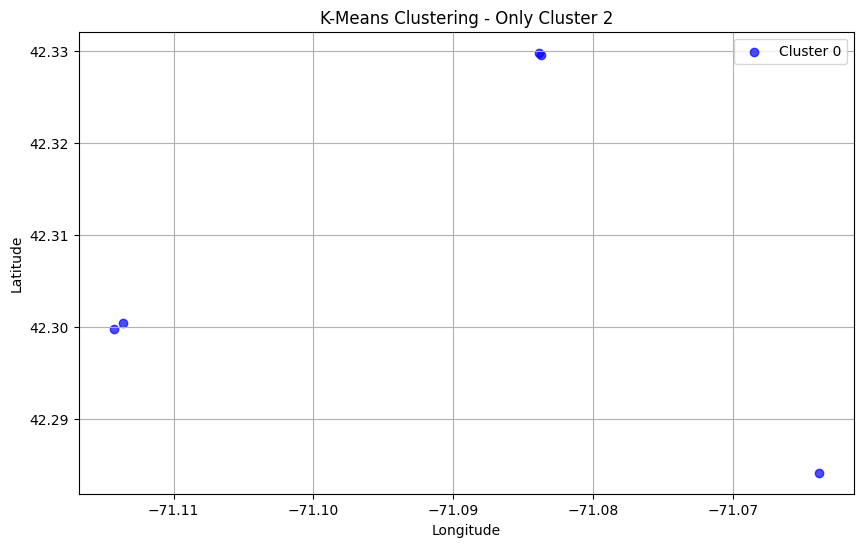

In [31]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 2]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 2")
plt.legend()
plt.grid(True)
plt.show()

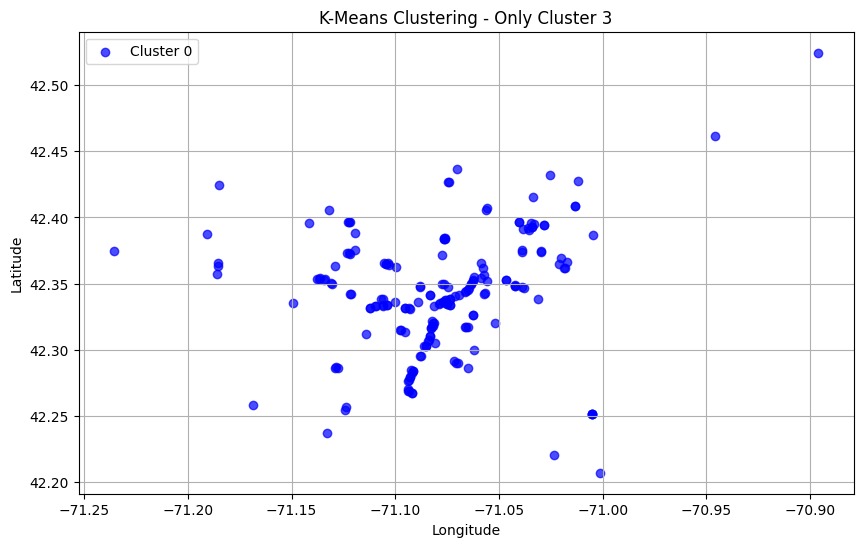

In [33]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 3]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 3")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from sklearn.preprocessing import StandardScaler

X_original = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
print(X_original)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
print(X_scaled)

       stop_lat   stop_lon      traffic
0     42.330957 -71.082754  1456.500000
1     42.332324 -71.081252  1445.600000
2     42.333021 -71.080799  3562.433333
3     42.335164 -71.078518  4495.455555
4     42.336339 -71.077070  7998.288888
...         ...        ...          ...
7269  42.372758 -70.971283   665.214285
7270  42.385674 -70.976635   114.100000
7271  42.385582 -70.976529    60.185714
7272  42.380764 -70.974996    61.500000
7276  42.360232 -70.971021     3.300000

[6720 rows x 3 columns]
[[-0.2962233  -0.09236823  0.1682272 ]
 [-0.28139085 -0.07559469  0.1654997 ]
 [-0.27382815 -0.07053583  0.69519295]
 ...
 [ 0.29647788  1.09389589 -0.18117124]
 [ 0.24420082  1.11101562 -0.18084236]
 [ 0.02142113  1.15540629 -0.1954057 ]]


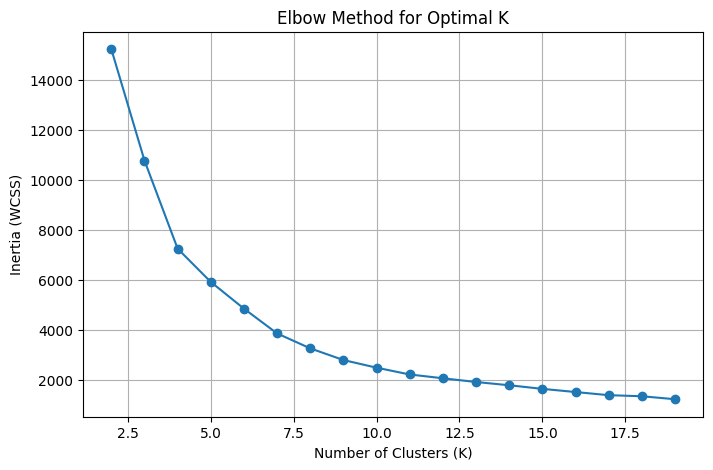

In [35]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

C:\Users\junhy\AppData\Local\Temp\ipykernel_33232\1267222859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["cluster"] = kmeans.fit_predict(X_scaled)


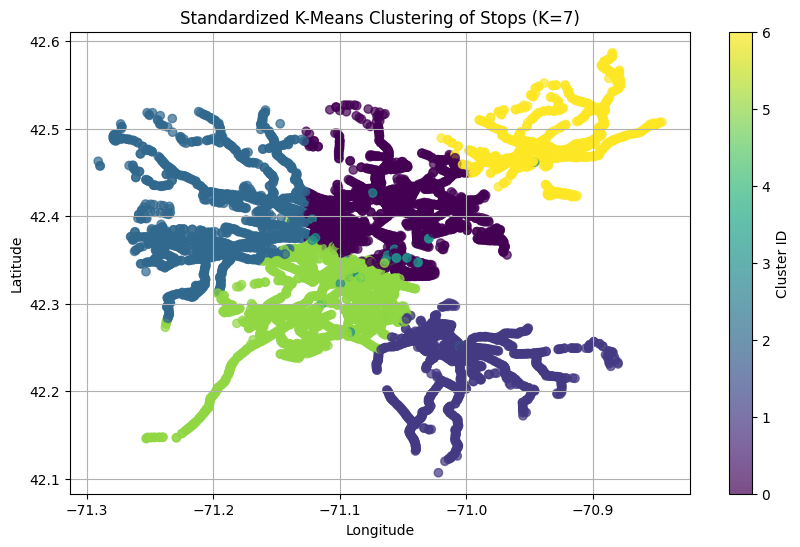

In [36]:
optimal_k = 7 
kmeans = KMeans(n_clusters=optimal_k)
grouped_df["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Standardized K-Means Clustering of Stops (K={optimal_k})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

In [37]:
cluster_lateness_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_lateness_summary

,cluster,traffic
0,0,679.359725
1,1,145.172467
2,2,246.718848
3,3,25091.056086
4,4,113158.321111
5,5,1079.383139
6,6,164.855390


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csv_file = "cleaned_final_set.csv"
df = pd.read_csv(csv_file)
df = df.dropna(subset=["stop_lat", "stop_lon"])
X = df[["stop_lat", "stop_lon", "traffic"]].copy()
X

,stop_lat,stop_lon,traffic
0,42.329789,-71.083887,2629.7
1,42.330957,-71.082754,75.2
2,42.332324,-71.081252,152.5
3,42.332016,-71.079576,67.3
4,42.331591,-71.076237,188.1
...,...,...,...
127162,42.359218,-71.105984,71.3
127163,42.361158,-71.103988,46.4
127164,42.363303,-71.101948,154.7
127165,42.364128,-71.103034,379.6


In [61]:
df['year'] = df['season'].str.extract(r'(\d{4})').astype(float)
df = df[df['year'] > 2019]

# Group data by stop_id and aggregate relevant columns
X_df = df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',    # Keep the first latitude value per stop
    'stop_lon': 'first',    # Keep the first longitude value per stop
    'traffic': 'sum'        # Sum up the traffic across all selected years
})

X_df['grouped_season'] = "2020 and beyond"

# Drop the grouped_season column
X_df.drop(columns='grouped_season', inplace=True)

print(X_df.tail())

      stop_id   stop_lat   stop_lon     traffic
6715   109898  42.372758 -70.971283  665.214285
6716   109899  42.385674 -70.976635  114.100000
6717   109900  42.385582 -70.976529   60.185714
6718   109901  42.380764 -70.974996   61.500000
6719   109912  42.360232 -70.971021    3.300000


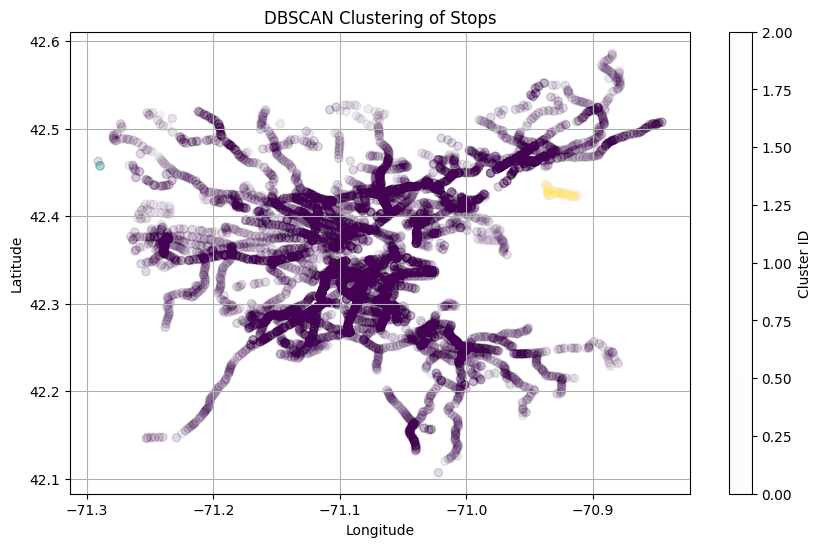

,cluster,traffic,num_stops
2,2,0.651471,204
1,1,3.375556,45
0,0,78.595430,67047


In [62]:
X_df = df[["stop_lon", "stop_lat"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=7)
df["cluster"] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["stop_lon"], df["stop_lat"], c=df["cluster"], cmap="viridis", alpha=0.01
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Stops")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()
cluster_ridership_summary = df.groupby("cluster").agg(
    traffic=("traffic", "mean"),   # Average traffic per cluster
    num_stops=("stop_id", "count") # Number of stops in each cluster
).reset_index()

cluster_ridership_summary = cluster_ridership_summary.sort_values(by="traffic")
cluster_ridership_summary